In [1]:
#import libraries
import sys
import scipy
import numpy as np
import math
import random

import pandas as pd

from pandas.io import sql
import sqlite3

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Cause plots to be displayed in the notebook:
%matplotlib inline

#print('Available plot styles: ' + str(plt.style.available))
plt.style.use('seaborn-dark')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#helper function for plotting a count distribution
def plot_distribution(datafile, field):
    return sns.countplot(x=field, data=datafile, palette='hls')

print('')
print('='*88)
print('CAPSTONE PROJECT - AI AUGMENTED PROJECT MANAGEMENT')
print('Author: \t Lawrance Koh (@LK)')
print('='*88)
print('Python: \t', sys.version)
print('Scipy:  \t', scipy.__version__)
print('SKLearn:  \t', sklearn.__version__)
print('Numpy:  \t', np.__version__)
print('Pandas: \t', pd.__version__)
print('MatPlotLib: \t', matplotlib.__version__)
print('SQLite3: \t', sqlite3.version)
print('='*88, "\n")

#suppress warnings
import warnings
warnings.filterwarnings("ignore")



CAPSTONE PROJECT - AI AUGMENTED PROJECT MANAGEMENT
Author: 	 Lawrance Koh (@LK)
Python: 	 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Scipy:  	 1.5.2
SKLearn:  	 0.23.2
Numpy:  	 1.19.2
Pandas: 	 1.1.3
MatPlotLib: 	 3.3.2
SQLite3: 	 2.6.0



<AxesSubplot:xlabel='label', ylabel='count'>

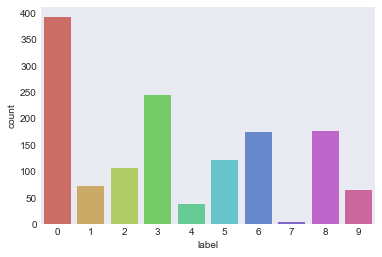

In [2]:
data = pd.read_excel('./Data/capstone_raw.xlsx', index_col=None, sheet_name='tasks_phrases')
data_dict = pd.read_excel('./Data/capstone_raw.xlsx', index_col=1, sheet_name='tag_dictionary')

#map tag with label referencing data dictionary
data['label'] = data['tag'].apply(lambda x: data_dict.loc[x]['label'])

plot_distribution(data, 'label') # view distribution of labels

#labels are nominal categorical 

In [3]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

import spacy
nlp = spacy.load('en_core_web_sm')

def parse_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)
    
    #clean up
    text = re.sub(r'[,-]', ' ', text)
    
    return text


In [4]:
%%time

X = data['task'].apply(parse_text)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer()
Xv_train = tv.fit_transform(X_train)
Xv_test = tv.transform(X_test)

Xv_train.shape, y_train.shape, Xv_test.shape, y_test.shape

Wall time: 4.14 s


((1046, 603), (1046,), (349, 603), (349,))

In [5]:
## helper functions

def train_model(classifier, feature_vector_train, label, feature_vector_valid, feature_vector_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    #return accuracy_score(predictions, y_test)
    return show_summary_report(feature_vector_test, predictions)

def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    f1_micro_ = f1_score(actual, prediction, average='micro')
    f1_macro_ = f1_score(actual, prediction, average='macro')
    f1_weighted_ = f1_score(actual, prediction, average='weighted')

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0' % accuracy_)
    print('F1 (Micro) : %.4f' % f1_micro_ )
    print('F1 (Macro) : %.4f' % f1_macro_ )
    print('F1 (Weighted) : %.4f' % f1_weighted_ )
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues')

    plt.show()
    
    return (accuracy_, f1_micro_, f1_macro_, f1_weighted_)

#initialise dataframe to view results
df_results = pd.DataFrame(columns=[['Accuracy', 'F1_Micro', 'F1_Macro', 'F1_Weighted']])


Accuracy : 0.7736 [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0
F1 (Micro) : 0.7736
F1 (Macro) : 0.6567
F1 (Weighted) : 0.7671
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


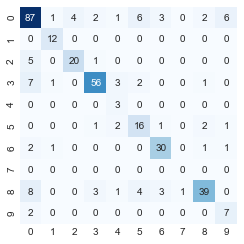

Wall time: 636 ms


In [6]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000)
df_results.loc['LogisticRegression'] = train_model(clf, Xv_train, y_train, Xv_test, y_test)


Accuracy : 0.7307 [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0
F1 (Micro) : 0.7307
F1 (Macro) : 0.5777
F1 (Weighted) : 0.7155
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


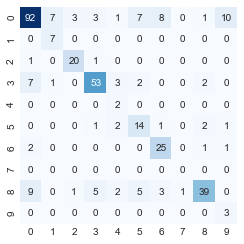

Wall time: 542 ms


In [7]:
%%time

from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
df_results.loc['MultiNomial_NaiveBayes'] = train_model(nb_clf, Xv_train, y_train, Xv_test, y_test)


Accuracy : 0.8252 [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0
F1 (Micro) : 0.8252
F1 (Macro) : 0.8233
F1 (Weighted) : 0.8219
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


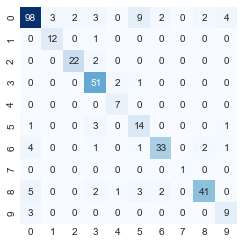

Wall time: 834 ms


In [8]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

df_results.loc['RandomForest'] = train_model(rf_clf, Xv_train, y_train, Xv_test, y_test)


Accuracy : 0.8252 [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0
F1 (Micro) : 0.8252
F1 (Macro) : 0.8253
F1 (Weighted) : 0.8234
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


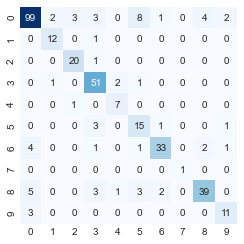

Wall time: 1.63 s


In [9]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

df_results.loc['GradientBoosting'] = train_model(gb_clf, Xv_train, y_train, Xv_test, y_test)


Accuracy : 0.8424 [TP / N] Proportion of predicted labels that match its tagged labels. Best: 1, Worst: 0
F1 (Micro) : 0.8424
F1 (Macro) : 0.8376
F1 (Weighted) : 0.8408
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


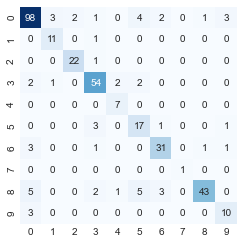

Wall time: 9.94 s


In [10]:
%%time

from sklearn.ensemble import StackingClassifier

estimators = [
    ('nb', nb_clf),
    ('rf', rf_clf),
    ('gb', gb_clf)]

stack_model = StackingClassifier(estimators=estimators, final_estimator=clf)

df_results.loc['StackModel'] = train_model(stack_model, Xv_train, y_train, Xv_test, y_test)


In [11]:
df_results

,Accuracy,F1_Micro,F1_Macro,F1_Weighted
LogisticRegression,0.773639,0.773639,0.656692,0.767086
MultiNomial_NaiveBayes,0.730659,0.730659,0.577705,0.715514
RandomForest,0.825215,0.825215,0.823288,0.821934
GradientBoosting,0.825215,0.825215,0.825298,0.823378
StackModel,0.842407,0.842407,0.837564,0.840847
